Trajectory Recommendation using Markov Chain
=====

<a id='sec1'></a>

# 1. Overview

### Features
Transition Features
1. POI category (a transition matrix between different categories)
1. POI popularity (a transition matrix between different class of popularity)
1. POI pair distance (a transition matrix between different class of distance)

### Recommend Trajectories
Given (start, end) and trajectory length $l$ for a specific user $u$, we'll recommend a trajectory to user $u$ as follows:
- Compute/enumerate all trajectories of length $l$ with (start, end) as candidates
- Use a uniform prior for all candidates
- Compute the likelihood of candidates using the above transition features estimated from travelling sequences in the training set
- Sort candidates by their posterior probabilities (i.e. $\text{prior} \times \text{likelihood}$) in descending order
- Recommend a trajectory from the top $K$ (e.g. 5) candidates with probability proportional to its posterior

**NOTE** that we use the same leave-one-out cross validation approach described in the [ijcai15 paper](#https://sites.google.com/site/limkwanhui/publications/2015-IJCAI-personalTour.pdf?attredirects=0), concretely, for each user $u$ in the dataset, choose one trajectory (length >= 3) from all trajectories of $u$ uniformly at random, this trajectory is used as the ground truth to measure the performance of the recommendation (i.e. compute the [precision, recall and F1-score](./ijcai15.ipynb#sec2.1)), all other trajectories are used to train/estimate parameters. So the training set will change when iterating through all users.

<a id='sec2'></a>

# 2. Load Data

In [1]:
%matplotlib inline

import os
import re
import sys
import math
import random
import pickle
import pandas as pd
import numpy as np
#import scipy.stats
#from numba import jit
import pylab
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import Parallel, delayed

In [2]:
nfeatures = 8 # number of features
EPS = 1e-12 # smooth, deal with 0 probability
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-' + suffix + '.pkl')
frand = os.path.join(data_dir, 'F1-rand-' + suffix + '.pkl')
flc = os.path.join(data_dir, 'F1-lc-' + suffix + '.pkl')
fse = os.path.join(data_dir, 'F1-se-' + suffix + '.pkl')
fid = os.path.join(data_dir, 'F1-id-' + suffix + '.pkl')
forand = os.path.join(data_dir, 'seq-rand-' + suffix + '.pkl')
folc = os.path.join(data_dir, 'seq-lc-' + suffix + '.pkl')
fose = os.path.join(data_dir, 'seq-se-' + suffix + '.pkl')
foid = os.path.join(data_dir, 'seq-id-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
#traj.head()

In [6]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


<a id='sec2.1'></a>

## 2.1 Compute POI Info

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [7]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [8]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [9]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
#poi_all.to_csv(fpoi, index=True)

<a id='sec2.2'></a>

## 2.2 Construct Travelling Sequences

In [10]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [11]:
seq_user = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_user.reset_index(inplace=True)
seq_user.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_user.set_index('seqID', inplace=True)
#seq_user.head()

In [12]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

<a id='sec3'></a>

# 3. Compute Transition Probabilities

<a id='sec3.1'></a>

## 3.1 Basic Definitions

- $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$:
   the transition probability from a POI of category $\text{Cat}_i$ to a POI of category $\text{Cat}_j$
- $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$:
   the transition probability from a POI of Popularity class $\text{Pop}_i$ to a POI of Popularity class $\text{Pop}_j$
- $\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$:
   the transition probability from a POI-POI pair with distance (between the two) class $\text{Dist}_i$ to a POI-POI pair with distance (between the two) class $\text{Dist}_j$

<a id='sec3.2'></a>

## 3.2 Transition Probabilities between POI Categories

We model transition probabilities between POI categories, i.e.
$\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j})$.

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a small number (i.e. $0.1$ times the minimum value of that row) if there exists a zero cell, use a uniform prior for all-zero rows.

In [13]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        nonzeroidx = np.nonzero(transmat.iloc[row])[0].tolist()
        
        if len(nonzeroidx) == 0: # all zero in this row
            transmat.iloc[row] = 1  # uniform prior
            
        elif len(nonzeroidx) < transmat.columns.shape[0]: # some cells are zero
            minv = np.min(transmat.iloc[row, nonzeroidx])
            EPS = 0.1 * minv  # row-specific smooth factor
            transmat.iloc[row] += EPS 
            
        rowsum = np.sum(transmat.iloc[row])
        assert(rowsum > 0)
        transmat.iloc[row] /= rowsum
    return transmat        

In [14]:
def calc_poi_cat_transmat(seqid_set, poi_all, seq_all):
    poi_cats = poi_all['poiTheme'].unique().tolist()
    poi_cats.sort()
    poi_cat_transmat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    index=poi_cats, columns=poi_cats)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            cat1 = poi_all.loc[poi1, 'poiTheme']
            cat2 = poi_all.loc[poi2, 'poiTheme']
            poi_cat_transmat.loc[cat1, cat2] += 1
    
    return normalise_transmat(poi_cat_transmat)

<a id='sec3.3'></a>

## 3.3 Transition Probabilities between POI Popularity Classes

We model transition probabilities between POI popularities, i.e.
$\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j})$
after discretizing POI popularities.

### 3.3.1 Discretize POI Popularity

Discretization method is choosen according to [this experiment](./traj_feature.ipynb#sec3.3).

In [15]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'seqID']].copy()
    poi_info = poi_info.groupby('poiID').agg(np.size)
    poi_info.rename(columns={'seqID':'popularity'}, inplace=True)
    #poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    # POI popularity discretization: quantile based bins
    #nbins = 9
    nbins = 5
    quantiles = np.round(np.linspace(0, 1, nbins+1), 2)[1:-1]
    bins_qt = [0]
    bins_qt.extend(poi_info['popularity'].quantile(quantiles))
    bins_qt.append(poi_info['popularity'].max() + 1)
    poi_info['popClass'] = np.digitize(poi_info['popularity'].get_values(), bins_qt)
    #print(poi_info)
    
    #assert(len(set(poi_info['popClass'].unique())) >= nbins) # NO empty bin
    
    return (poi_info, nbins)

### 3.3.2 Compute Transition Probabilities

In [16]:
def calc_poi_pop_transmat(seqid_set, nbins_pop, poi_all, seq_all):
    pop_class = np.arange(1, nbins_pop+1)
    poi_pop_transmat = pd.DataFrame(data=np.zeros((len(pop_class), len(pop_class)), dtype=np.float), \
                                    index=pop_class, columns=pop_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            pc1 = poi_all.loc[poi1, 'popClass']
            pc2 = poi_all.loc[poi2, 'popClass']
            poi_pop_transmat.loc[pc1, pc2] += 1
    #print(poi_pop_transmat)
    return normalise_transmat(poi_pop_transmat)

<a id='sec3.4'></a>

## 3.4 Transition Probabilities between POI Pair Distance Classes

We model transition probabilities between different POI pair distances, i.e.
$\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})$
after discretize POI pair distances.

### TODO: Improve the distance calculation using Google maps [distance API](https://developers.google.com/maps/documentation/distance-matrix/intro) with different [travel modes](https://developers.google.com/maps/documentation/distance-matrix/intro#travel_modes) demonstrated [here](https://jakevdp.github.io/blog/2015/10/17/analyzing-pronto-cycleshare-data-with-python-and-pandas/).

### 3.4.1 Discretize POI Pair Distance

In [17]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin( math.sqrt( \
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

Discretization method is choosen according to [this experiment](./traj_feature.ipynb#sec3.4).

In [18]:
def calc_poipair_distclass_mat(poi_all):
    poi_distmat = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                               index=poi_all.index, columns=poi_all.index)
    distdata = []
    for i in range(poi_all.index.shape[0]):
        poi1 = poi_all.index[i]
        for j in range(i+1, poi_all.index.shape[0]):
            poi2 = poi_all.index[j]
            dist = calc_dist(poi_all.loc[poi1, 'poiLon'], poi_all.loc[poi1, 'poiLat'], \
                             poi_all.loc[poi2, 'poiLon'], poi_all.loc[poi2, 'poiLat'])
            poi_distmat.loc[poi1, poi2] = dist
            poi_distmat.loc[poi2, poi1] = dist
            distdata.append(dist)
            
    # discretize POI pair distance: quantile based bins
    distdata = pd.Series(distdata)
    #nbins = 10
    nbins = 5
    quantiles = np.round(np.linspace(0, 1, nbins+1), 2)[1:-1]
    bins_qt = [0]
    bins_qt.extend(distdata.quantile(quantiles))
    bins_qt.append(10*round(distdata.max()))
    
    poipair_distclass_mat = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.int), \
                                         index=poi_all.index, columns=poi_all.index)
    for i in range(poi_all.index.shape[0]):
        poi1 = poi_all.index[i]
        for j in range(i+1, poi_all.index.shape[0]):
            poi2 = poi_all.index[j]
            dc = np.digitize([poi_distmat.loc[poi1, poi2]], bins_qt)[0]
            poipair_distclass_mat.loc[poi1, poi2] = dc
            poipair_distclass_mat.loc[poi2, poi1] = dc
    
    #assert(len(set(poipair_distclass_mat.get_values().flatten())) > nbins) # No empty bin, NOTE zero diagonal
    if len(set(poipair_distclass_mat.get_values().flatten())) <= nbins:
        print('Bins:', np.arange(1, nbins+1))
        print(poipair_distclass_mat)
    
    return (poipair_distclass_mat, nbins)

### 3.4.2 Compute Transition Probabilities

Use POI pair that is **observed** in dataset to compute the transition matrix between different "class" of distances.

In [19]:
def calc_poipair_dist_transmat(seqid_set, nbins_dist, seq_all, poipair_distclass_mat):
    dist_class = np.arange(1, nbins_dist+1)
    poipair_dist_transmat = pd.DataFrame(data=np.zeros((len(dist_class), len(dist_class)), dtype=np.float), \
                                         index=dist_class, columns=dist_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) < 3: continue
        for j in range(1, len(seq)-1):
            poi1 = seq[j-1]
            poi2 = seq[j]
            poi3 = seq[j+1]
            dc1 = poipair_distclass_mat.loc[poi1, poi2]
            dc2 = poipair_distclass_mat.loc[poi2, poi3]
            poipair_dist_transmat.loc[dc1, dc2] += 1
    return normalise_transmat(poipair_dist_transmat)

<a id='sec4'></a>

# 4. Compute Trajectory Likelihood

Log likelihood of trajectory $[\text{POI}_1, \text{POI}_2, \dots, \text{POI}_i, ..., \text{POI}_N]$ is defined as
\begin{align}
\text{logl} =& 
\sum_{i=1}^{N-1} \log(\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_{i+1}})) + 
\sum_{i=1}^{N-1} \log(\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_{i+1}})) + 
\sum_{i=2}^{N-1} \log(\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to 
\text{Dist}_{\text{POI}_{i} \to \text{POI}_{i+1}})) \\
& + \log(\text{Pr}(\text{POI}_1)) 
\end{align}

where $\text{Pr}(\text{POI}_1)$ is the prior of $\text{POI}_1$ and we assume $\text{Pr}(\text{POI}_1)=1.0$, 10-based logarithm is used here.

In [20]:
def calc_seq_loglikelihood(seq, poi_all, poi_cat_transmat_log, poi_pop_transmat_log, \
                           poi_distclass_mat, poipair_dist_transmat_log):
    assert(len(seq) > 1)
    cat1 = poi_all.loc[seq[0], 'poiTheme']
    cat2 = poi_all.loc[seq[1], 'poiTheme']
    pc1  = poi_all.loc[seq[0], 'popClass']
    pc2  = poi_all.loc[seq[1], 'popClass']
    logL = poi_cat_transmat_log.loc[cat1, cat2] + poi_pop_transmat_log.loc[pc1, pc2]
    for j in range(1, len(seq)-1):
        poi1 = seq[j-1]
        poi2 = seq[j]
        poi3 = seq[j+1]
        cat2 = poi_all.loc[poi2, 'poiTheme']
        cat3 = poi_all.loc[poi3, 'poiTheme']
        pc2  = poi_all.loc[poi2, 'popClass']
        pc3  = poi_all.loc[poi3, 'popClass']
        dc12 = poi_distclass_mat.loc[poi1, poi2]
        dc23 = poi_distclass_mat.loc[poi2, poi3]
        logL += poi_cat_transmat_log.loc[cat2, cat3] + poi_pop_transmat_log.loc[pc2, pc3]
        #print(seq, dc12, dc23)
        logL += poipair_dist_transmat_log.loc[dc12, dc23]
    return logL

<a id='sec5'></a>

# 5. Trajectory Recommendation & Evaluation

Parameter estimation of the Markov Chain.

In [21]:
def estimate_parameter(seqid_set_training, poi_all, seq_all):
    # compute POI info using training set
    (poi_info, nbins_pop) = calc_poi_info(seqid_set_training, seq_all, poi_all)
    
    # compute POI category transition matrix
    poi_cat_transmat = calc_poi_cat_transmat(seqid_set_training, poi_info, seq_all)
    poi_cat_transmat_log = np.log10(poi_cat_transmat)
    
    # compute POI popularity transition matrix    
    poi_pop_transmat = calc_poi_pop_transmat(seqid_set_training, nbins_pop, poi_info, seq_all)
    poi_pop_transmat_log = np.log10(poi_pop_transmat)
    
    # compute POI pair distance transition matrix
    (poipair_distclass_mat, nbins_dist) = calc_poipair_distclass_mat(poi_info)
    poipair_dist_transmat = calc_poipair_dist_transmat(seqid_set_training, nbins_dist, seq_all, poipair_distclass_mat)
    poipair_dist_transmat_log = np.log10(poipair_dist_transmat)
    
    return (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)    

Enumerate trajectories of the same (start, end) and length (3, 4 or 5) with respect to an actual sequence.

In [22]:
def enum_seq345(start, end, length, poi_list): 
    assert(length in {3, 4, 5})
    p0 = start
    pN = end
    
    # enumerate sequences with length 3
    if length == 3:
        return [[p0, p, pN] \
                for p in poi_list if p not in {p0, pN}]
    
    # enumerate sequences with length 4
    if length == 4:
        return [[p0, p1, p2, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN}]
    
    # enumerate sequences with length 5
    if length == 5:
        return [[p0, p1, p2, p3, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN} \
                for p3 in poi_list if p3 not in {p0, p1, p2, pN}]

In [23]:
def parse_seqstr(seqstr):
    term = re.sub('[ \[\]]', '', seqstr).split(',')
    return [int(x) for x in term]

With uniform prior, the posterior probability of trajectory is proportional to its likelihood.

In [24]:
def recommend_trajectory(start, end, length, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, \
                         poipair_distclass_mat, poipair_dist_transmat_log):    
    # enumerate trajectory
    poi_list = poi_info.index.tolist()
    enum_seqs = enum_seq345(start, end, length, poi_list)
    
    # compute log likelihood
    # parallel: OK
    #t1 = datetime.now()
    #logL = Parallel(n_jobs=-2)(delayed(calc_seq_loglikelihood)\
    #       (seq, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)\
    #       for seq in enum_seqs)
    #print('%d seconds used' % (datetime.now()-t1).total_seconds())
    
    # sequential
    logL = []
    for seq in enum_seqs:
        logl = calc_seq_loglikelihood(seq, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, \
                                      poipair_distclass_mat, poipair_dist_transmat_log)
        logL.append(logl)
    
    # sanity check: passed
    #seq1 = [10, 21, 28, 22]
    #dc12 = poipair_distclass_mat.loc[seq1[0], seq1[1]]
    #dc23 = poipair_distclass_mat.loc[seq1[1], seq1[2]]
    #dc34 = poipair_distclass_mat.loc[seq1[2], seq1[3]]
    #s1 = poi_cat_transmat_log.loc[poi_info.loc[seq1[0], 'poiTheme'], poi_info.loc[seq1[1], 'poiTheme']] + \
    #     poi_cat_transmat_log.loc[poi_info.loc[seq1[1], 'poiTheme'], poi_info.loc[seq1[2], 'poiTheme']] + \
    #     poi_cat_transmat_log.loc[poi_info.loc[seq1[2], 'poiTheme'], poi_info.loc[seq1[3], 'poiTheme']] + \
    #     poi_pop_transmat_log.loc[poi_info.loc[seq1[0], 'popClass'], poi_info.loc[seq1[1], 'popClass']] + \
    #     poi_pop_transmat_log.loc[poi_info.loc[seq1[1], 'popClass'], poi_info.loc[seq1[2], 'popClass']] + \
    #     poi_pop_transmat_log.loc[poi_info.loc[seq1[2], 'popClass'], poi_info.loc[seq1[3], 'popClass']]
    #s2 = poipair_dist_transmat_log.loc[dc12, dc23] + poipair_dist_transmat_log.loc[dc23, dc34]
    #logL1 = calc_seq_loglikelihood(seq1, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, \
    #                               poipair_distclass_mat, poipair_dist_transmat_log)
    #print(s1+s2, '==', logL1, '?')
    
    # dataframe of enumerated trajectories
    enum_seq_df = pd.DataFrame(data=np.array(logL), index=[str(x) for x in enum_seqs], columns=['logLikelihood'])
    
    # sort by loglikeilihood in descending order
    enum_seq_df.sort(columns=['logLikelihood'], ascending=False, inplace=True)
    
    # recommend trajectory
    probs = enum_seq_df['logLikelihood'].get_values(); #print(probs)
    probs = np.exp(probs)
    probs /= np.sum(probs); #print(probs)
    #enum_seq_df['probability'] = probs
    
    # recommend a trajectory with probability proportional to its posterior (i.e. likelihood when prior is uniform)
    #sample = np.random.multinomial(1, probs) # catgorical/multinoulli distribution, multinomial distribution (n=1)
    #idx = sample.nonzero()[0][0]
    #return (parse_seqstr(enum_seq_df.index[idx]), probs[idx]) # return the recommended sequence and its probability
    
    # recommend the topk trajectories with their probabilities
    k = 10
    if enum_seq_df.shape[0] < k: 
        k = enum_seq_df.shape[0]
    result_df = enum_seq_df.iloc[0:k].copy()
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index':'sequence'}, inplace=True)
    result_df.drop('logLikelihood', axis=1, inplace=True)
    result_df['probability'] = probs[0:k]
    return result_df

Use F1 measure defined [here](./ijcai15.ipynb#sec2.1) to evaluate the performance of recommender.

In [25]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    actset = set(seq_act)
    recset = set(seq_rec)
    intersect = actset & recset
    recall = len(intersect) / len(seq_act)
    precision = len(intersect) / len(seq_rec)
    F1score = 2. * precision * recall / (precision + recall)
    return F1score

Evaluation on test set.

In [26]:
def evaluate_parallel(seqid_set, poi_all, seq_all, poi_cat_transmat_log, poi_pop_transmat_log, \
             poipair_distclass_mat, poipair_dist_transmat_log):
    seq_act_list = [extract_seq(seqid, seq_all) for seqid in seqid_set]
    seq_rec_df_list = Parallel(n_jobs=-2)(delayed(recommend_trajectory)\
                      (seq[0], seq[-1], len(seq), poi_all, poi_cat_transmat_log, \
                       poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) \
                      for seq in seq_act_list)    
    seq_rec_list = [parse_seqstr(seq_rec_df.iloc[0]['sequence']) for seq_rec_df in seq_rec_df_list]
    assert(len(seq_act_list) == len(seq_rec_list))
    #F1scores = [calc_F1score(seq_act_list[x], seq_rec_list[x]) for x in range(len(seq_act_list))] # OK
    F1scores = Parallel(n_jobs=-2)(delayed(calc_F1score)\
               (seq_act_list[x], seq_rec_list[x]) for x in range(len(seq_act_list))) # OK
                                   
    return F1scores

In [27]:
def evaluate_sequential(seqid_set, poi_all, seq_all, poi_cat_transmat_log, poi_pop_transmat_log, \
             poipair_distclass_mat, poipair_dist_transmat_log):
    F1scores = []
    for seqid in seqid_set:
        seq_act = extract_seq(seqid, seq_all)
        seq_rec_df = recommend_trajectory(seq_act[0], seq_act[-1], len(seq_act), poi_all, poi_cat_transmat_log, \
                                          poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
        seq_rec = parse_seqstr(seq_rec_df.iloc[0]['sequence']) # choose the one with max posterior
        F1 = calc_F1score(seq_act, seq_rec)
        F1scores.append(F1)
        #print('Actual: %-23s  Recommended: %-23s F1: %.2f' % (str(seq_act), str(seq_rec), F1)); sys.stdout.flush()
    return F1scores

<a id='sec6'></a>

# 6. Active Learning without Personalisation

**Notations**

- $Traj$: a trajectory
- $|Traj|$: the number of POIs in trajectory $Traj$
- $P_s$: the `start` (first) POI of a trajectory
- $P_e$: the `end` (last) POI of a trajectory
- $T_s$: the earlist start time of a trajectory
- $T_e$: the latest end time of a trajectory
- $u$: a specific user
- $\textbf{x}$: an example
- $\textbf{y}$: label of an example $\textbf{x}$

- Example: $\textbf{x} = (P_s, P_e, T_s, T_e, |Traj|)$
- Label of Example: $\textbf{y} = Traj$
- Assume that all examples are i.i.d.

<a id='sec5.1'></a>

### 5.1 Travelling Sequences Dataset Partition

Split dataset (travelling sequences with length 3/4/5) into 
- training set (i.e. initial training) ~~(10%)~~ (30%), 
- annotation set (i.e. simulate user annotation) (50%), 
- evaluation set (a.k.a. test set) ~~(40%)~~ (20%).

**Problem**:
- when the initial training set is too small such that the travelling sequences in training set can not span all POIs in annotation/evaluation set, then the annotation/evaluation will fail. 

In [28]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
print(seq_stats.index.shape[0])

6057


In [29]:
seqid_set_exp = seq_stats[seq_stats['seqLen'].isin({3, 4, 5})].index
print(len(seqid_set_exp))

309


Choose a random portion of sequences as training data that span all POIs in annotation/evaluation set.

In [30]:
seqid_set_training0 = []
seqid_set_annotate0 = []
seqid_set_evaluate0 = []

In [31]:
doCompute = True

In [32]:
if os.path.exists(fseqpart):
    doCompute = False
    (seqid_set_training0, seqid_set_annotate0, seqid_set_evaluate0) = pickle.load(open(fseqpart, 'rb'))

In [33]:
if doCompute:
    idx_range = np.arange(len(seqid_set_exp))
    num_train = round(len(seqid_set_exp) * 0.3)
    num_annotate = round(len(seqid_set_exp) * 0.5)
    poi_coverage_ok = False
    for i in range(200):
        np.random.shuffle(idx_range) 
        seqid_set_training0 = list(seqid_set_exp[idx_range[0:num_train]])
        seqid_set_annotate0 = list(seqid_set_exp[idx_range[num_train:num_train+num_annotate]])
        seqid_set_evaluate0 = list(seqid_set_exp[idx_range[num_train+num_annotate:]])
        poi_set_training = {poi for seqid in seqid_set_training0 for poi in extract_seq(seqid, seq_all)}
        poi_set_annotate = {poi for seqid in seqid_set_annotate0 for poi in extract_seq(seqid, seq_all)}
        poi_set_evaluate = {poi for seqid in seqid_set_evaluate0 for poi in extract_seq(seqid, seq_all)}
        #print(len(poi_set_training), len(poi_set_annotate), len(poi_set_evaluate))
        #for seqid in seqid_set_training0: poi_set_training = poi_set_training | set(extract_seq(seqid, seq_all))
        if len(poi_set_training & poi_set_annotate) == len(poi_set_annotate) and \
           len(poi_set_training & poi_set_evaluate) == len(poi_set_evaluate):
            poi_coverage_ok = True
            pickle.dump((seqid_set_training0, seqid_set_annotate0, seqid_set_evaluate0), open(fseqpart, 'wb'))
            break
    if poi_coverage_ok == False:
        print('Failed to find a training set of sequences that span all POIs in annotation/evaluation set.')

In [34]:
print(len(seqid_set_exp))
print(len(seqid_set_training0))
print(len(seqid_set_annotate0))
print(len(seqid_set_evaluate0))

309
93
154
62


### 5.2 Random Baseline

Query strategy: choose a random example in annotation set to query (passive learning).

Make a copy of training set and annotation set and use the copies.

In [35]:
seqid_set_training = list(seqid_set_training0)
seqid_set_annotate = list(seqid_set_annotate0)
seqid_set_evaluate = list(seqid_set_evaluate0)

In [36]:
query_order = np.arange(len(seqid_set_annotate))
np.random.shuffle(query_order)

In [37]:
F1_scores_rand = []
seq_order_rand = []

In [38]:
doCompute = True

In [39]:
if os.path.exists(frand) and os.path.exists(forand)
    doCompute = False
    F1_scores_rand = pickle.load(open(frand, 'rb'))
    seq_order_rand = pickle.load(open(forand, 'rb'))

Estimate parameters using the initial training set.

In [40]:
if doCompute:
    (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
    estimate_parameter(seqid_set_training, poi_all, seq_all)

Sanity check: evaluate using the first example in test set.

In [41]:
if doCompute:
    seqid = seqid_set_evaluate[0]
    seq_act = extract_seq(seqid, seq_all)
    seq_rec_df = recommend_trajectory(seq_act[0], seq_act[-1], len(seq_act), poi_info, poi_cat_transmat_log, \
                                      poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
    seq_rec = parse_seqstr(seq_rec_df.iloc[0]['sequence']) # choose the one with max posterior
    F1 = calc_F1score(seq_act, seq_rec) 
    print('Actual: %-23s  Recommended: %-23s F1: %.2f' % (str(seq_act), str(seq_rec), F1))
    seq_rec_df

Recommend trajectories using the initial training set and evaluate on test set.

In [42]:
if doCompute:
    F1scores = evaluate_parallel(seqid_set_evaluate, poi_info, seq_all, poi_cat_transmat_log, \
                                 poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
    F1_scores_rand.append(F1scores)
    print('Evaluation 0, F1 mean: %.2f, std: %.2f' % (np.mean(F1_scores_rand[-1]), np.std(F1_scores_rand[-1])))
    sys.stdout.flush()

Evaluate the baseline on test set using random query strategy.

In [43]:
if doCompute:
    n = 1
    for idx in query_order:
        # choose sequence to query
        seqid = seqid_set_annotate[idx]
        
        # add query result to training set, here just add the sequence id to training set
        seq_order_rand.append(seqid)
        seqid_set_training.append(seqid)
        
        # estimate parameters using current training set
        (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
        estimate_parameter(seqid_set_training, poi_all, seq_all)
        
        # evaluate on test set
        F1scores = evaluate_parallel(seqid_set_evaluate, poi_info, seq_all, poi_cat_transmat_log, \
                                     poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
        F1_scores_rand.append(F1scores)
        print('Evaluation %-2d/%d, F1 mean: %.2f, std: %.2f' % \
              (n, len(seqid_set_annotate0), np.mean(F1_scores_rand[-1]), np.std(F1_scores_rand[-1])))
        sys.stdout.flush()
        n += 1
        
    pickle.dump(F1_scores_rand, open(frand, 'wb'))
    pickle.dump(seq_order_rand, open(forand, 'wb'))

Plot the learning curve.

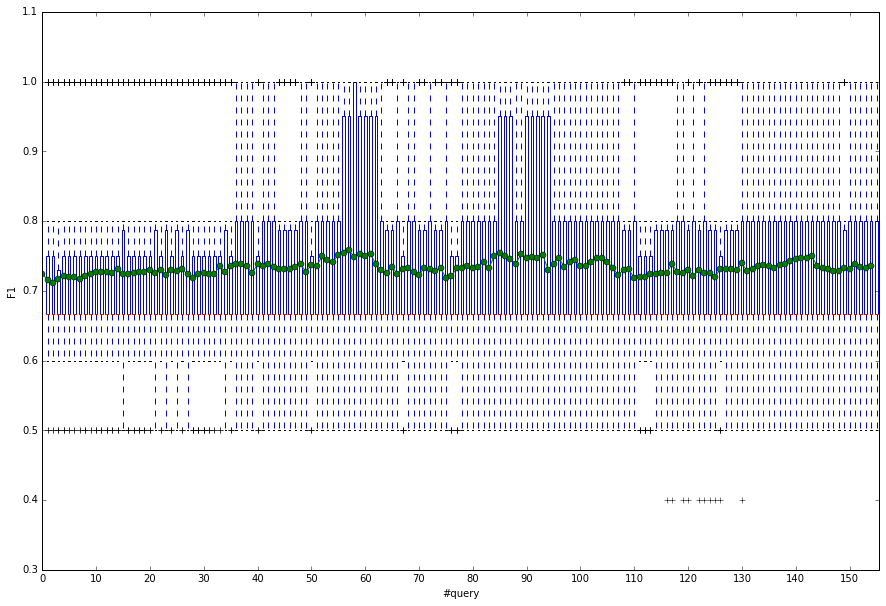

In [114]:
plt.figure(figsize=[15, 10])
plt.boxplot(F1_scores_rand)
plt.plot(np.arange(len(F1_scores_rand)), [np.mean(x) for x in F1_scores_rand], color='g', marker='o')
#plt.plot(np.arange(len(seqid_set_annotate)+1), F1_random, marker='s', color='g', linestyle='--', label='random baseline')
#plt.errorbar(np.arange(len(seqid_set_annotate0)+1), F1_mean_rand, yerr=F1_std_rand, color='g', \
#             linestyle='--', marker='s', label='random baseline')
plt.ylim([0.3, 1.1])
xticks = [10*x for x in range(int(round(len(F1_scores_rand), -1)/10))]
plt.xticks(xticks, xticks) # xticks starts from 1
plt.xlabel('#query')
plt.ylabel('F1')
#plt.legend(loc='lower right')

### 5.3 Least Confident Strategy

Query Strategy:
\begin{equation}
\phi^{LC}(\textbf{x}) = 1 - P(\textbf{y}^* | \textbf{x}; \Theta)
\end{equation}
where $\textbf{y}^*$ is the most likely label of example $\textbf{x}$ with respect to a probabilistic model of which the parameters are denoted by $\Theta$.  
This query strategy select the example $\textbf{x}$ of maximum $\phi^{LC}$ from all unlabelled examples in a pool to query.

**Problem**:
- This query strategy biases to sequences with more POIs, as the number of candidate trajectories grows exponentially as the number of POIs specified, the probability of the most likely candidate trajectory becomes smaller and smaller.

Make a copy of training set and annotation set and use the copies.

In [45]:
seqid_set_training = list(seqid_set_training0)
seqid_set_annotate = list(seqid_set_annotate0)
seqid_set_evaluate = list(seqid_set_evaluate0)

In [46]:
F1_scores_lc = []
seq_order_lc = []

In [47]:
doCompute = True

In [48]:
if os.path.exists(flc) and os.path.exists(folc):
    doCompute = False
    F1_scores_lc = pickle.load(open(flc, 'rb'))
    seq_order_lc = pickle.load(open(folc, 'rb'))

Recommend trajectories using the initial training set and evaluate on test set.

In [49]:
#(poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
#estimate_parameter(seqid_set_training, poi_all, seq_all)

In [50]:
#print(poi_info)
#print(poi_cat_transmat_log)
#print(poi_pop_transmat_log)

In [51]:
#seq_act = [8, 19, 22]
#seq_rec_df = recommend_trajectory(seq_act[0], seq_act[-1], len(seq_act), poi_info, poi_cat_transmat_log, \
#                                  poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
#print(seq_act); print(seq_rec_df); print(); sys.stdout.flush()

In [52]:
if doCompute:
    (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
    estimate_parameter(seqid_set_training, poi_all, seq_all)
    F1scores = evaluate_parallel(seqid_set_evaluate, poi_info, seq_all, poi_cat_transmat_log, \
                                 poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
    F1_scores_lc.append(F1scores)
    print('Evaluation 0, F1 mean: %.2f, std: %.2f' % (np.mean(F1_scores_lc[-1]), np.std(F1_scores_lc[-1])))
    sys.stdout.flush()

Evaluate the baseline on test set using least confident query strategy.

In [53]:
if doCompute:
    n = 1
    seqs_annotate = [extract_seq(seqid, seq_all) for seqid in seqid_set_annotate]
    # repeat until all sequences in annotation set have been queried 
    while len(seqid_set_annotate) > 0:
        # choose sequence to query
        # sequential: OK
        #seq_idx = 0; max_lc = 0
        #for idx in range(len(seqid_set_annotate)):
        #    seq_act = seqs_annotate[idx]
        #    seq_rec_df = recommend_trajectory(seq_act[0], seq_act[-1], len(seq_act), poi_info, poi_cat_transmat_log, \
        #                                      poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
        #    #print(seq_act); print(seq_rec_df); print(); sys.stdout.flush()
        #    maxprob = seq_rec_df.iloc[0]['probability']
        #    assert(not np.isnan(maxprob))
        #    lc = 1 - maxprob
        #    if lc > max_lc:
        #        max_lc = lc; seq_idx = idx
                
        # parallel
        seq_rec_df_list = Parallel(n_jobs=-2)(delayed(recommend_trajectory)\
                          (seq[0], seq[-1], len(seq), poi_info, poi_cat_transmat_log, \
                           poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) \
                          for seq in seqs_annotate)
        maxprobs = np.array([seq_rec_df.iloc[0]['probability'] for seq_rec_df in seq_rec_df_list])
        assert(np.any(np.isnan(maxprobs)) == False) # No NaN value
        #lc = 1 - maxprobs
        #seq_idx = np.argmax(lc)
        seq_idx = np.argmin(maxprobs)

        # add query result to training set, here just add the sequence id to training set
        seq_order_lc.append(seqid_set_annotate[seq_idx])
        seqid_set_training.append(seqid_set_annotate[seq_idx])
        print('Choose sequence %-23s, LC: %.4f' % (str(seqs_annotate[seq_idx]), 1-maxprobs[seq_idx])); sys.stdout.flush()

        # remove the selected example from annotation set
        del seqid_set_annotate[seq_idx]
        del seqs_annotate[seq_idx]

        # estimate parameters using the updated training set
        (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
        estimate_parameter(seqid_set_training, poi_all, seq_all)

        # evaluate on test set
        F1scores = evaluate_parallel(seqid_set_evaluate, poi_info, seq_all, poi_cat_transmat_log, \
                                     poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
        F1_scores_lc.append(F1scores)
        print('Evaluation %-3d/%d, F1 mean: %.2f, std: %.2f' % \
              (n, len(seqid_set_annotate0), np.mean(F1_scores_lc[-1]), np.std(F1_scores_lc[-1])))
        sys.stdout.flush()
        n += 1
        
    pickle.dump(F1_scores_lc, open(flc, 'wb'))
    pickle.dump(seq_order_lc, open(folc, 'wb'))

Plot the learning curve.

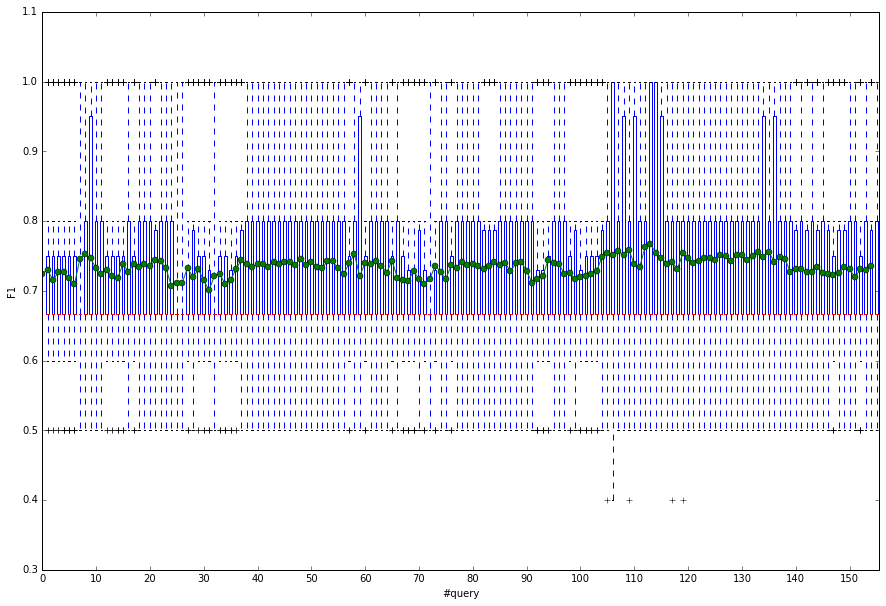

In [113]:
plt.figure(figsize=[15, 10])
plt.boxplot(F1_scores_lc, labels=np.arange(len(F1_scores_lc)))
plt.plot(np.arange(len(F1_scores_lc)), [np.mean(x) for x in F1_scores_lc], color='g', marker='o')
#plt.errorbar(np.arange(len(seqid_set_annotate0)+1), F1_mean_rand, yerr=F1_std_rand, \
#             linestyle='--', marker='s', label='random baseline')
#plt.errorbar(np.arange(len(seqid_set_annotate0)+1), F1_mean_lc, yerr=F1_std_lc, \
#             linestyle='--', marker='s', label='least confident')
xticks = [10*x for x in range(int(round(len(F1_scores_lc), -1)/10))]
plt.xticks(xticks, xticks) # xticks starts from 1
plt.ylim([0.3, 1.1])
plt.xlabel('#query')
plt.ylabel('F1')
#plt.legend(loc='lower right')

### 5.4 Maximum Sequence Entropy Strategy

\begin{equation}
\phi^{SE}(\textbf{x}) = - \sum_{\hat{\textbf{y}}} P(\hat{\textbf{y}} | \textbf{x}; \Theta) 
\log(P(\hat{\textbf{y}} | \textbf{x}; \Theta))
\end{equation}
where $\hat{\textbf{y}}$ ranges over all possible labels for example $\textbf{x}$.  
**Note** that the number of possible labels grows exponentially with $|Traj|$ in $\textbf{x}$, to make computation feasible,
[Kim06](http://www.aclweb.org/anthology/N06-2018) used the $N$-best possible labels to approximate, concretely, 
define **N-best Sequence Entropy** as
\begin{equation}
\phi^{NSE}(\textbf{x}) = - \sum_{\hat{\textbf{y}} \in \mathcal{N}} P(\hat{\textbf{y}} | \textbf{x}; \Theta) 
\log(P(\hat{\textbf{y}} | \textbf{x}; \Theta))
\end{equation}
where $\mathcal{N} = \{\textbf{y}_1^*, \dots, \textbf{y}_N^*\}$ is the set of the $N$ most likely labels of example $\textbf{x}$.  
This query strategy select the example $\textbf{x}$ of maximum $\phi^{SE}$ or $\phi^{NSE}$ from all unlabelled examples in a pool to query.

Make a copy of training set and annotation set and use the copies.

In [55]:
seqid_set_training = list(seqid_set_training0)
seqid_set_annotate = list(seqid_set_annotate0)
seqid_set_evaluate = list(seqid_set_evaluate0)

In [56]:
F1_scores_se = []
seq_order_se = []

In [57]:
doCompute = True

In [58]:
if os.path.exists(fse) and os.path.exists(fose):
    doCompute = False
    F1_scores_se = pickle.load(open(fse, 'rb'))
    seq_order_se = pickle.load(open(fose, 'rb'))

Recommend trajectories using the initial training set and evaluate on test set.

In [59]:
if doCompute:
    (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
    estimate_parameter(seqid_set_training, poi_all, seq_all)
    F1scores = evaluate_parallel(seqid_set_evaluate, poi_info, seq_all, poi_cat_transmat_log, \
                                 poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
    F1_scores_se.append(F1scores)
    print('Evaluation 0, F1 mean: %.2f, std: %.2f' % (np.mean(F1_scores_se[-1]), np.std(F1_scores_se[-1])))
    sys.stdout.flush()

Compute sequence entropy.

In [60]:
def calc_sequence_entropy(start, end, length, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, \
                          poipair_distclass_mat, poipair_dist_transmat_log):    
    # enumerate trajectory
    poi_list = poi_info.index.tolist()
    enum_seqs = enum_seq345(start, end, length, poi_list)

    # sequential
    logL = []
    for seq in enum_seqs:
        logl = calc_seq_loglikelihood(seq, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, \
                                      poipair_distclass_mat, poipair_dist_transmat_log)
        logL.append(logl)
    
    probs = np.array(logL)
    probs = np.exp(probs)
    probs /= np.sum(probs) # normalise
    
    return -1 * np.dot(probs, np.log10(probs))

Evaluate the baseline on test set using sequence entropy query strategy.

In [61]:
if doCompute:
    n = 1
    seqs_annotate = [extract_seq(seqid, seq_all) for seqid in seqid_set_annotate]
    # repeat until all sequences in annotation set have been queried 
    while len(seqid_set_annotate) > 0:
        # choose sequence to query
        seq_entropy_list = Parallel(n_jobs=-2)(delayed(calc_sequence_entropy)\
                           (seq[0], seq[-1], len(seq), poi_info, poi_cat_transmat_log, \
                            poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) \
                           for seq in seqs_annotate)
        assert(np.any(np.isnan(np.array(seq_entropy_list))) == False) # No NaN value
        seq_idx = np.argmax(np.array(seq_entropy_list))

        # add query result to training set, here just add the sequence id to training set
        seq_order_se.append(seqid_set_annotate[seq_idx])
        seqid_set_training.append(seqid_set_annotate[seq_idx])
        print('Choose sequence %23s, SE: %.4f' % (str(seqs_annotate[seq_idx]), seq_entropy_list[seq_idx]))
        sys.stdout.flush()

        # remove the selected example from annotation set
        del seqid_set_annotate[seq_idx]
        del seqs_annotate[seq_idx]

        # estimate parameters using the updated training set
        (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
        estimate_parameter(seqid_set_training, poi_all, seq_all)

        # evaluate on test set
        F1scores = evaluate_parallel(seqid_set_evaluate, poi_info, seq_all, poi_cat_transmat_log, \
                                     poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
        F1_scores_se.append(F1scores)
        print('Evaluation %-3d/%d, F1 mean: %.2f, std: %.2f' % \
              (n, len(seqid_set_annotate0), np.mean(F1_scores_se[-1]), np.std(F1_scores_se[-1])))
        sys.stdout.flush()
        n += 1
        
    pickle.dump(F1_scores_se, open(fse, 'wb'))
    pickle.dump(seq_order_se, open(fose, 'wb'))    

Plot the learning curve.

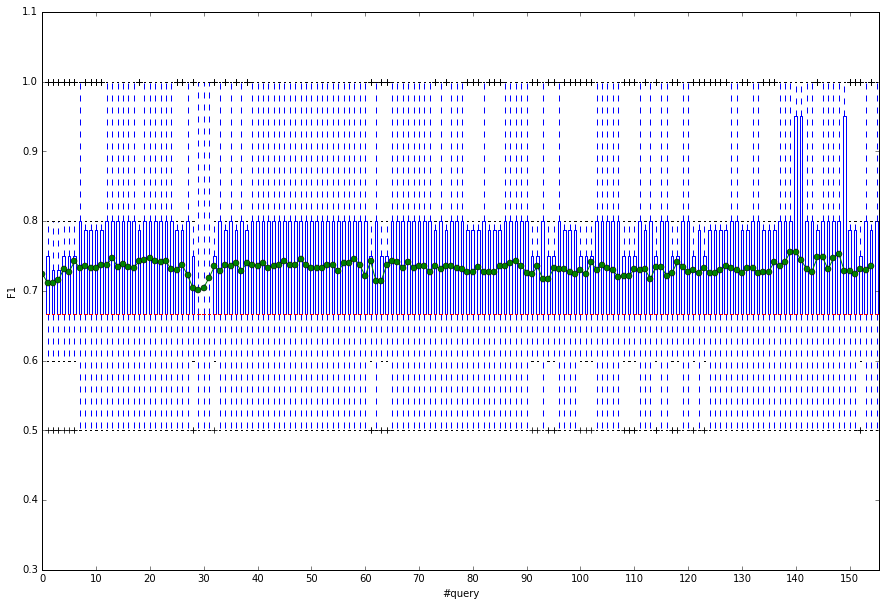

In [110]:
plt.figure(figsize=[15, 10])
plt.boxplot(F1_scores_se)
plt.plot(np.arange(len(F1_scores_se)), [np.mean(x) for x in F1_scores_se], color='g', marker='o')
xticks = [10*x for x in range(int(round(len(F1_scores_se), -1)/10))]
plt.xticks(xticks, xticks) # xticks starts from 1
plt.ylim([0.3, 1.1])
plt.xlabel('#query')
plt.ylabel('F1')
#plt.legend(loc='lower right')

### 5.5 Maximum Information Density Strategy

\begin{equation}
\phi^{ID}(\textbf{x}) = \phi^{SE}(\textbf{x}) \times 
\left(
\frac{1}{U} \sum_{u=1}^U \text{sim}(\textbf{x}, \textbf{x}^u)
\right)^\beta
\end{equation}
That is, the informativeness of example $\textbf{x}$ is weighted by its average similarity to all other unlabelled examples (denoted by $\mathcal{U})$ in the pool, subject to parameter $\beta$ which was set to $1$ in [Settles08](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.187.7401&rep=rep1&type=pdf) giving no reason, 
sequence entropy $\phi^{SE}$ measures the "base" informativeness and could be replaced by $\phi^{NSE}$ defined above.  
This query strategy select the example $\textbf{x}$ of maximum $\phi^{ID}$ from all unlabelled examples in a pool to query.

Define a function to compute the simularity between two trajectories, [Settles08](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.187.7401&rep=rep1&type=pdf) uses cosine simularity after transforming a sequence into a fixed length feature vector.

Let sequence $i$ $[p_{i_1}, p_{i_2}, \dots, p_{i_{N1}}]$ and sequence $j$ $[p_{j_1}, p_{j_2}, \dots, p_{j_{N1}}]$,
define the similarity between sequence $i$ and $j$ as follows:
\begin{equation}
\text{sim}([p_{i_1}, p_{i_2}, \dots, p_{i_{N1}}], [p_{j_1}, p_{j_2}, \dots, p_{j_{N1}}]) = 
\frac{\lvert [p_{i_1}, p_{i_2}, \dots, p_{i_{N1}}] \cap [p_{j_1}, p_{j_2}, \dots, p_{j_{N1}}] \rvert}
     {\lvert [p_{i_1}, p_{i_2}, \dots, p_{i_{N1}}] \cup [p_{j_1}, p_{j_2}, \dots, p_{j_{N1}}] \rvert}
\end{equation}

In [63]:
def calc_sequence_similarity(seq1, seq2):
    assert(len(seq1) > 0 and len(seq2) > 0)
    return len(set(seq1) & set(seq2)) / len(set(seq1) | set(seq2))

Make a copy of training set and annotation set and use the copies.

In [64]:
seqid_set_training = list(seqid_set_training0)
seqid_set_annotate = list(seqid_set_annotate0)
seqid_set_evaluate = list(seqid_set_evaluate0)

Compute the simularity between all pair of unlabelled exmaples.  
**NOTE** that there are duplicate sequences exist.

In [65]:
distinct_seqstr_list = {str(extract_seq(seqid, seq_all)) for seqid in seqid_set_annotate0}
seqs_annotate0 = [parse_seqstr(seqstr) for seqstr in sorted(distinct_seqstr_list)] # distinct sequences
seq_sim_mat = pd.DataFrame(data=np.zeros((len(seqs_annotate0), len(seqs_annotate0)), dtype=np.float), \
                           index=[str(x) for x in seqs_annotate0], columns=[str(x) for x in seqs_annotate0])
for i in range(len(seqs_annotate0)):
    for j in range(i, len(seqs_annotate0)):
        sim = calc_sequence_similarity(seqs_annotate0[i], seqs_annotate0[j])
        assert(not np.isnan(sim))
        seq_sim_mat.iloc[i, j] = sim
        seq_sim_mat.iloc[j, i] = sim

Sanity check.

In [66]:
seq_sim_mat.head()

,"[1, 30, 4]","[1, 30, 7]","[11, 13, 30]","[11, 22, 23, 21]","[11, 24, 16, 7]","[11, 29, 7]","[13, 16, 29]","[13, 24, 16]","[16, 11, 23]","[16, 22, 29]",...,"[8, 16, 1]","[8, 16, 22]","[8, 16, 4, 1, 29]","[8, 16, 4, 22]","[8, 16, 7]","[8, 19, 22]","[8, 24, 30]","[8, 30, 16]","[8, 30, 28, 23]","[8, 4, 16]"
"[1, 30, 4]",1.0,0.500000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.200000,0.000000,0.333333,0.166667,0.0,0.000000,0.200000,0.200000,0.166667,0.200000
"[1, 30, 7]",0.5,1.000000,0.200000,0.000000,0.166667,0.200000,0.000000,0.0,0.0,0.000000,...,0.200000,0.000000,0.142857,0.000000,0.2,0.000000,0.200000,0.200000,0.166667,0.000000
"[11, 13, 30]",0.2,0.200000,1.000000,0.166667,0.166667,0.200000,0.200000,0.2,0.2,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.200000,0.166667,0.000000
"[11, 22, 23, 21]",0.0,0.000000,0.166667,1.000000,0.142857,0.166667,0.000000,0.0,0.4,0.166667,...,0.000000,0.166667,0.000000,0.142857,0.0,0.166667,0.000000,0.000000,0.142857,0.000000
"[11, 24, 16, 7]",0.0,0.166667,0.166667,0.142857,1.000000,0.400000,0.166667,0.4,0.4,0.166667,...,0.166667,0.166667,0.125000,0.142857,0.4,0.000000,0.166667,0.166667,0.000000,0.166667


In [67]:
k = 5
sumk = seq_sim_mat.iloc[k].sum()
sumk /= len(seqs_annotate0)
sumk = sumk**1
print(sumk)

0.100595238095


In [68]:
sums=[(np.sum([seq_sim_mat.loc[str(x), str(y)] for y in seqs_annotate0])/len(seqs_annotate0))**1 for x in seqs_annotate0]
sums

[0.11134453781512604,
 0.15213585434173668,
 0.096848739495798308,
 0.21778711484593835,
 0.14343487394957982,
 0.10059523809523808,
 0.090371148459383752,
 0.087815126050420175,
 0.14880952380952381,
 0.16785714285714287,
 0.25099789915966381,
 0.23102532679738561,
 0.20733543417366948,
 0.17941176470588238,
 0.10675770308123249,
 0.20588235294117646,
 0.15830415499533146,
 0.22120973389355739,
 0.042498249299719883,
 0.028676470588235293,
 0.028676470588235293,
 0.028676470588235293,
 0.21843487394957983,
 0.15843837535014005,
 0.15262605042016805,
 0.27563025210084036,
 0.23961834733893556,
 0.22380952380952379,
 0.255234593837535,
 0.22191876750700282,
 0.16036414565826329,
 0.21031162464985995,
 0.21010445845004663,
 0.20552345938375349,
 0.092542016806722693,
 0.23246965452847804,
 0.21151960784313725,
 0.16950280112044816,
 0.17941176470588238,
 0.24033321661998136,
 0.2304096638655462,
 0.19902836134453783,
 0.23308823529411762,
 0.22743347338935571,
 0.22722338935574229,
 0.27

In [69]:
F1_scores_id = []
seq_order_id = []

In [70]:
doCompute = True

In [71]:
if os.path.exists(fid) and os.path.exists(foid):
    doCompute = False
    F1_scores_id = pickle.load(open(fid, 'rb'))
    seq_order_id = pickle.load(open(foid, 'rb'))

Recommend trajectories using the initial training set and evaluate on test set.

In [72]:
if doCompute:
    (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
    estimate_parameter(seqid_set_training, poi_all, seq_all)
    F1scores = evaluate_parallel(seqid_set_evaluate, poi_info, seq_all, poi_cat_transmat_log, \
                                 poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
    F1_scores_id.append(F1scores)
    print('Evaluation 0, F1 mean: %.2f, std: %.2f' % (np.mean(F1_scores_id[-1]), np.std(F1_scores_id[-1])))
    sys.stdout.flush()

Evaluate the baseline on test set using information density query strategy.

In [73]:
if doCompute:
    n = 1
    beta = 1
    seqs_annotate = [extract_seq(seqid, seq_all) for seqid in seqid_set_annotate]
    # repeat until all sequences in annotation set have been queried 
    while len(seqid_set_annotate) > 0:
        # choose sequence to query
        seq_entropy_list = Parallel(n_jobs=-2)(delayed(calc_sequence_entropy)\
                           (seq[0], seq[-1], len(seq), poi_info, poi_cat_transmat_log, \
                            poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) \
                           for seq in seqs_annotate)
        assert(np.any(np.isnan(np.array(seq_entropy_list))) == False) # No NaN value
        seq_sim_list = [(np.sum([seq_sim_mat.loc[str(x), str(y)] for y in seqs_annotate])/len(seqs_annotate))**beta \
                        for x in seqs_annotate]
        assert(len(seq_entropy_list) == len(seq_sim_list))
        seq_ids = np.multiply(np.array(seq_entropy_list), np.array(seq_sim_list))
        seq_idx = np.argmax(seq_ids)

        # add query result to training set, here just add the sequence id to training set
        seq_order_id.append(seqid_set_annotate[seq_idx])
        seqid_set_training.append(seqid_set_annotate[seq_idx])
        print('Choose sequence %23s, ID:%.4f' % (str(seqs_annotate[seq_idx]), seq_ids[seq_idx]))
        sys.stdout.flush()

        # remove the selected example from annotation set
        del seqid_set_annotate[seq_idx]
        del seqs_annotate[seq_idx]

        # estimate parameters using the updated training set
        (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
        estimate_parameter(seqid_set_training, poi_all, seq_all)

        # evaluate on test set
        F1scores = evaluate_parallel(seqid_set_evaluate, poi_info, seq_all, poi_cat_transmat_log, \
                                     poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
        F1_scores_id.append(F1scores)
        print('Evaluation %-3d/%d, F1 mean: %.2f, std: %.2f' % \
              (n, len(seqid_set_annotate0), np.mean(F1_scores_id[-1]), np.std(F1_scores_id[-1])))
        sys.stdout.flush()
        n += 1
        
    pickle.dump(F1_scores_id, open(fse, 'wb'))
    pickle.dump(seq_order_id, open(fose, 'wb'))

Plot the learning curve.

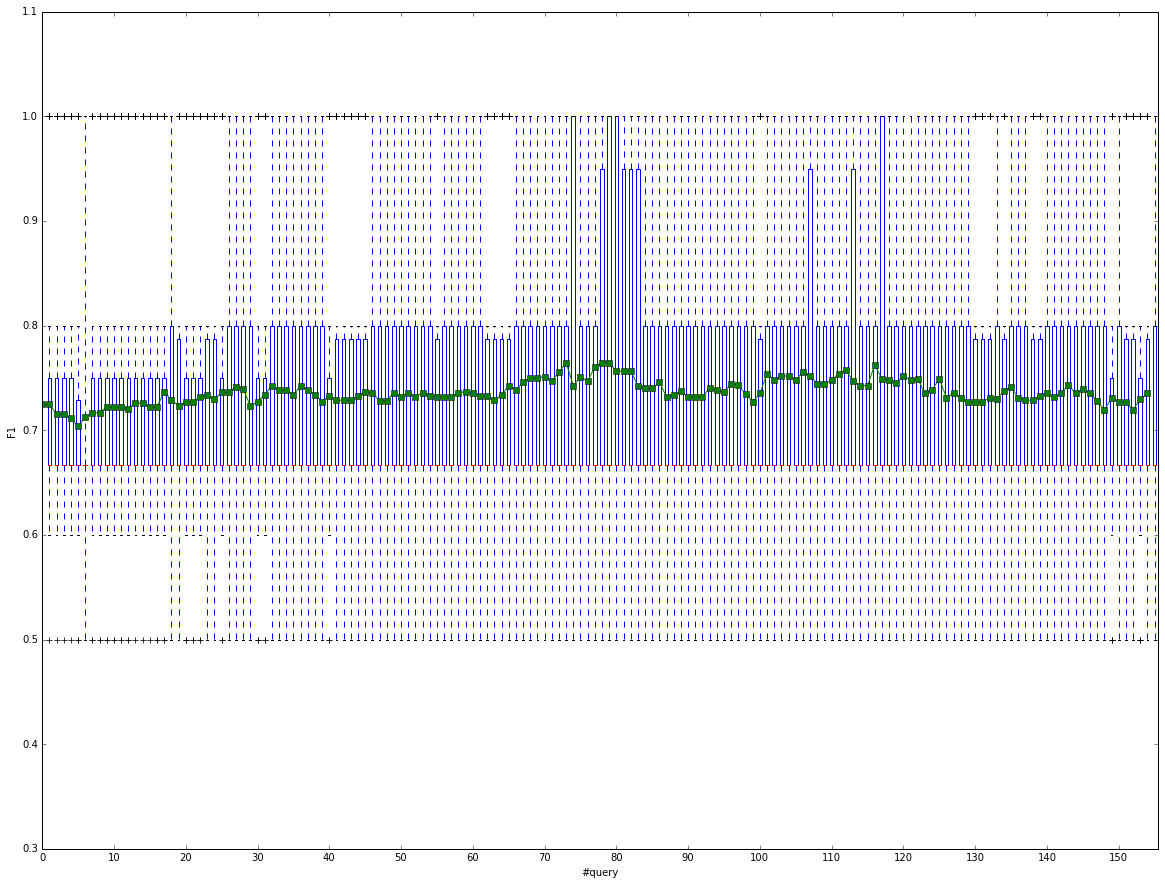

In [74]:
plt.figure(figsize=[20, 15])
plt.boxplot(F1_scores_id)
plt.plot(np.arange(len(F1_scores_id)), [np.mean(x) for x in F1_scores_id], color='g', marker='s')
xticks = [10*x for x in range(int(round(len(F1_scores_id), -1)/10))]
plt.xticks(xticks, xticks) # xticks starts from 1
plt.ylim([0.3, 1.1])
plt.xlabel('#query')
plt.ylabel('F1')
#plt.legend(loc='lower right')

### 5.6 Performance Comparison

Random guessing probability.

In [97]:
n3 = seq_stats[seq_stats['seqLen'] == 3].shape[0]
n4 = seq_stats[seq_stats['seqLen'] == 4].shape[0]
n5 = seq_stats[seq_stats['seqLen'] == 5].shape[0]
nseq = n3 + n4 + n5
npoi = seq_all[seq_all['seqID'].isin(seqid_set_exp)]['poiID'].unique().shape[0]

In [98]:
from scipy.misc import comb
from math import factorial
prob3 = (1*comb(1, 1) + (2/3)*comb(npoi-3, 1)) / (npoi-2)
prob4 = (1*comb(2, 2) + (3/4)*comb(2, 1)*comb(npoi-4, 1) + (2/4)*comb(npoi-4, 2)) * factorial(2) / ((npoi-2) * (npoi-3))
prob5 = (1*comb(3, 3) + (4/5)*comb(3, 2)*comb(npoi-5, 1) + (3/5)*comb(3, 1)*comb(npoi-5, 2) + (2/5)*comb(npoi-5, 3)) * \
        factorial(3) / ((npoi-2) * (npoi-3) * (npoi-4))

In [100]:
randguess = prob3 * (n3 / nseq) + prob4 * (n4 / nseq) + prob5 * (n5 / nseq)
print(randguess)

0.632756437315


Compare learning curves using the mean of F1.

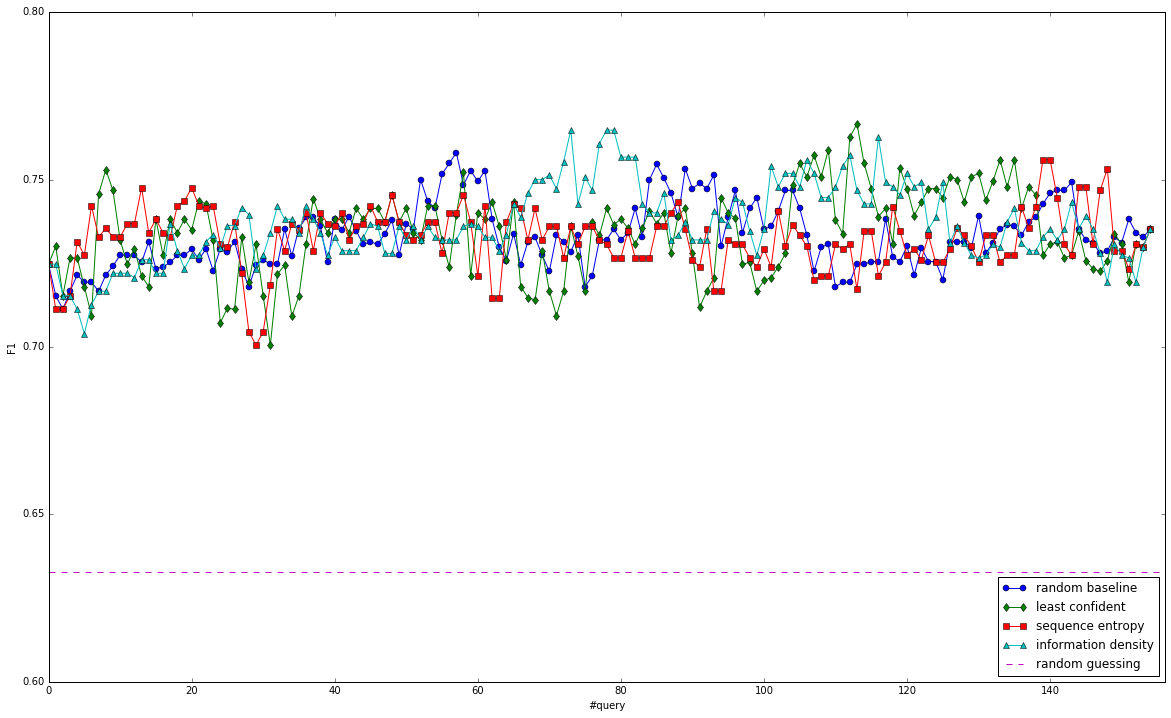

In [109]:
plt.figure(figsize=[20, 12])
plt.plot(np.arange(len(F1_scores_rand)), [np.mean(x) for x in F1_scores_rand], marker='o', label='random baseline')
plt.plot(np.arange(len(F1_scores_lc)),   [np.mean(x) for x in F1_scores_lc],   marker='d', label='least confident')
plt.plot(np.arange(len(F1_scores_se)),   [np.mean(x) for x in F1_scores_se],   marker='s', label='sequence entropy')
plt.plot(np.arange(len(F1_scores_id)),   [np.mean(x) for x in F1_scores_id],   marker='^', label='information density')
plt.plot([0, len(F1_scores_rand)+1], [randguess, randguess], linestyle='--', label='random guessing')
plt.xlim([0, len(F1_scores_rand)+1])
plt.ylim([0.6, 0.8])
plt.xlabel('#query')
plt.ylabel('F1')
plt.legend(loc='lower right')

Compare learning curves using the median of F1.

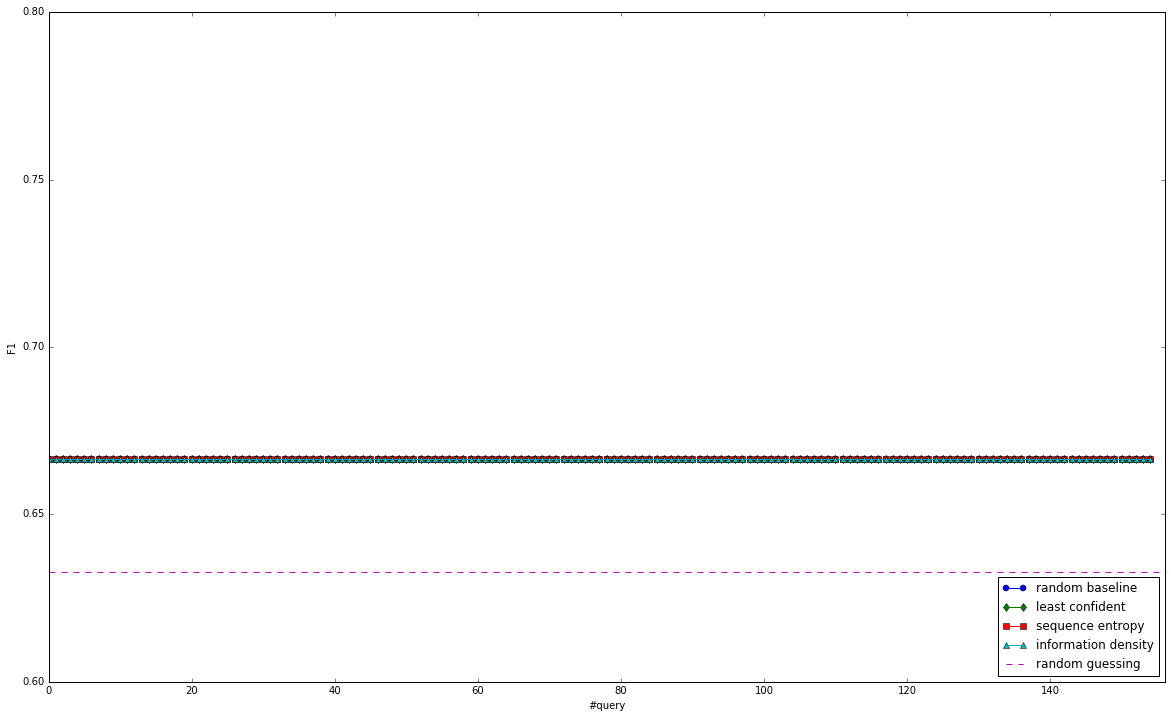

In [107]:
plt.figure(figsize=[20, 12])
plt.plot(np.arange(len(F1_scores_rand)), [np.median(x) for x in F1_scores_rand], marker='o', label='random baseline')
plt.plot(np.arange(len(F1_scores_lc)),   [np.median(x) for x in F1_scores_lc],   marker='d', label='least confident')
plt.plot(np.arange(len(F1_scores_se)),   [np.median(x) for x in F1_scores_se],   marker='s', label='sequence entropy')
plt.plot(np.arange(len(F1_scores_id)),   [np.median(x) for x in F1_scores_id],   marker='^', label='information density')
plt.plot([0, len(F1_scores_rand)+1], [randguess, randguess], linestyle='--', label='random guessing')
plt.xlim([0, len(F1_scores_rand)+1])
plt.ylim([0.6, 0.8])
plt.xlabel('#query')
plt.ylabel('F1')
plt.legend(loc='lower right')